Logistic Regression Model and Threshold Calibration to classify is review if positive or not

In [1]:
import pandas as pd
url_train = 'https://github.com/aws-samples/aws-machine-learning-embark-nlp/raw/master/DATA/NLP/EMBK-NLP-FINAL-TRAIN-CSV.csv'
url_test = 'https://github.com/aws-samples/aws-machine-learning-embark-nlp/raw/master/DATA/NLP/EMBK-NLP-FINAL-TEST-CSV.csv'
#df = pd.read_csv(url,index_col=0,parse_dates=[0])
train_df = pd.read_csv(url_train,parse_dates=[0])
test_df = pd.read_csv(url_test,parse_dates=[0])

In [2]:
train_df.head()

,reviewText,summary,verified,time,log_votes,isPositive
0,"PURCHASED FOR YOUNGSTER WHO\nINHERITED MY ""TOO...",IDEAL FOR BEGINNER!,True,1361836800,0.000000,1.0
1,unable to open or use,Two Stars,True,1452643200,0.000000,0.0
2,Waste of money!!! It wouldn't load to my system.,Dont buy it!,True,1433289600,0.000000,0.0
3,I attempted to install this OS on two differen...,I attempted to install this OS on two differen...,True,1518912000,0.000000,0.0
4,I've spent 14 fruitless hours over the past tw...,Do NOT Download.,True,1441929600,1.098612,0.0


In [3]:
test_df.head()

,reviewText,summary,verified,time,log_votes,isPositive
0,Kaspersky offers the best security for your co...,State of the art protection,True,1465516800,0.000000,1.0
1,This Value was extremely discounted which I ap...,Quickbooks,True,1393632000,0.000000,1.0
2,Some dufus probably got stock options by the t...,Sad,False,1228176000,2.639057,0.0
3,I have reviewed the software and it is beyond ...,Excellent product,True,1402531200,0.000000,1.0
4,"Plain old simple you need Anti-Virus,I have tr...",A must have,True,1367539200,0.000000,1.0


# 2. Exploratory data analysis and missing value imputation

In [7]:
train_df["isPositive"].value_counts()

1.0    43692
0.0    26308
Name: isPositive, dtype: int64

In [8]:
test_df["isPositive"].value_counts()

1.0    4980
0.0    3020
Name: isPositive, dtype: int64

Checking the number of missing values:

In [9]:
print(train_df.isna().sum())

reviewText    11
summary       14
verified       0
time           0
log_votes      0
isPositive     0
dtype: int64


In [10]:
print(test_df.isna().sum())

reviewText    2
summary       1
verified      0
time          0
log_votes     0
isPositive    0
dtype: int64


Let's fill-in a placeholder for the reviewText missing values:

In [12]:
train_df["reviewText"].fillna("Missing", inplace=True)
test_df["reviewText"].fillna("Missing", inplace=True)

# 3. Stop word removal and stemming

In [5]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\solharsh\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\solharsh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [13]:
import nltk, re
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.tokenize import word_tokenize
stop = stopwords.words('english')

# These words are important for our problem. We don't want to remove them.
excluding = ['against', 'not', 'don', "don't",'ain', 'aren', "aren't", 'couldn', "couldn't",
             'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 'hasn', "hasn't", 
             'haven', "haven't", 'isn', "isn't", 'mightn', "mightn't", 'mustn', "mustn't",
             'needn', "needn't",'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', 
             "weren't", 'won', "won't", 'wouldn', "wouldn't"]
stop_words = [word for word in stop if word not in excluding]

In [15]:
snow = SnowballStemmer('english')

In [24]:
def process_text(texts): 
    final_text_list=[]
    for sent in texts:
        filtered_sentence=[]
        sent = sent.lower() # Lowercase 
        sent = sent.strip() # Remove leading/trailing whitespace
        sent = re.sub('\s+', ' ', sent) # Remove extra space and tabs
        sent = re.compile('<.*?>').sub('', sent) # Remove HTML tags/markups:
        for w in word_tokenize(sent):
            # Check if it is not numeric and its length>2 and not in stop words
            if(not w.isnumeric()) and (len(w)>2) and (w not in stop_words):  
                # Stem and add to filtered list
                filtered_sentence.append(snow.stem(w))
        final_string = " ".join(filtered_sentence) #final string of cleaned words
        final_text_list.append(final_string)
    return final_text_list

In [25]:
print("Pre-processing training reviewText")
train_df["reviewText"] = process_text(train_df["reviewText"].tolist())
print("Pre-processing test reviewText")
test_df["reviewText"] = process_text(test_df["reviewText"].tolist())

Pre-processing training reviewText
Pre-processing test reviewText


# 4. Splitting the training dataset into training and validation

In [26]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(train_df["reviewText"].tolist(), # Input
                                                  train_df["isPositive"].tolist(), # Target field
                                                  test_size=0.10, # 10% test, 90% tranining
                                                  shuffle=True) # Shuffle the whole dataset

# 5. Computing Bag of Words Features

In [27]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

X_test = test_df["reviewText"].tolist()
y_test = test_df["isPositive"].tolist()
# Initialize the binary count vectorizer
tfidf_vectorizer = CountVectorizer(binary=True,
                                   max_features=50 # Limit the vocabulary size
                                  )
# Fit and transform
X_train_text_vectors = tfidf_vectorizer.fit_transform(X_train)
# Only transform
X_val_text_vectors = tfidf_vectorizer.transform(X_val)
# Only transform
X_test_text_vectors = tfidf_vectorizer.transform(X_test)

# 6. Fitting LogisticRegression and checking model performance

Let's fit LogisticRegression from Sklearn library, and check the performance on the validation dataset.

In [28]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import make_scorer, accuracy_score, f1_score
# To improve the performance of LogisticRegression we can tune its parameters, for example:
# * regularization type: penalty = {l1, l2, elasticnet}
# * regularization strength: C = {smaller values specify stronger regularization} 
#    !!! LogisticRegression regularized cost function: C*Cost(w) + penalty(w), 
# where w is the weights vector !!!
# * addressing class imbalance: 
# class_weight = {balanced or {class label:weight, class label:weight}, ...}
lrClassifier = LogisticRegression(penalty = 'l2',
                                  C = 0.1,
                                  class_weight = 'balanced')
lrClassifier.fit(X_train_text_vectors, y_train)
lrClassifier_val_predictions = lrClassifier.predict(X_val_text_vectors)
lrClassifier_test_predictions = lrClassifier.predict(X_test_text_vectors)
 
print("LogisticRegression on Validation: Accuracy Score: %f, F1-score: %f" % \
      (accuracy_score(y_val, lrClassifier_val_predictions), f1_score(y_val, lrClassifier_val_predictions)))

print("LogisticRegression on Test: Accuracy Score: %f, F1-score: %f" % \
      (accuracy_score(y_test, lrClassifier_test_predictions), f1_score(y_test, lrClassifier_test_predictions)))

C:\Users\solharsh\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression on Validation: Accuracy Score: 0.753286, F1-score: 0.802696
LogisticRegression on Test: Accuracy Score: 0.748750, F1-score: 0.795566


# Probability threshold calibration 

Besides tuning LogisticRegression hyperparameter values, one other path to improve a classifier's performance is to dig deeper into how the classifier actually assigns class membership.

Binary predictions versus probability predictions. We often use classifier.predict() to examine classifier binary predictions, while in fact the outputs of most classifiers are real-valued, not binary. For most classifiers in sklearn, the method classifier.predict_proba() returns class probabilities as a two-dimensional numpy array of shape (n_samples, n_classes) where the classes are lexicographically ordered.

For our example, let's look at the first 5 predictions we made, in binary format and in real-valued probability format:


In [30]:
lrClassifier.predict(X_val_text_vectors)[0:5]

array([1., 1., 1., 1., 1.])

In [31]:
lrClassifier.predict_proba(X_val_text_vectors)[0:5]

array([[0.28561337, 0.71438663],
       [0.20401744, 0.79598256],
       [0.39139561, 0.60860439],
       [0.31529154, 0.68470846],
       [0.39139561, 0.60860439]])

How are the predicted probabilities used to decide class membership? On each row of predict_proba output, the probabilities values sum to 1. There are two columns, one for each response class: column 0 - predicted probability that each observation is a member of class 0; column 1 - predicted probability that each observation is a member of class 1. From the predicted probabilities, choose the class with the highest probability.

The key here is that a threshold of 0.5 is used by default (for binary problems) to convert predicted probabilities into class predictions: class 0, if predicted probability is less than 0.5; class 1, if predicted probability is greater than 0.5.

Can we improve classifier performance by changing the classification threshold? Let's adjust the classification threshold to influence the performance of the classifier.

### Threshold calibration to improve model accuracy

Highest Accuracy on Validation: 0.7637142857142857 , Threshold for the highest Accuracy: 0.39


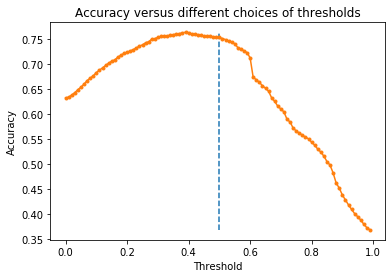

In [32]:
 
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
 
# Calculate the accuracy using different values for the classification threshold, 
# and pick the threshold that resulted in the highest accuracy.

highest_accuracy = 0
threshold_highest_accuracy = 0

thresholds = np.arange(0,1,0.01)
scores = []
for t in thresholds:
    # set threshold to 't' instead of 0.5
    y_val_other = (lrClassifier.predict_proba(X_val_text_vectors)[:,1] >= t).astype(float)
    score = accuracy_score(y_val, y_val_other)
    scores.append(score)
    if(score > highest_accuracy):
        highest_accuracy = score
        threshold_highest_accuracy = t

print("Highest Accuracy on Validation:", highest_accuracy, \
      ", Threshold for the highest Accuracy:", threshold_highest_accuracy)   

# Let's plot the accuracy versus different choices of thresholds

plt.plot([0.5, 0.5], [np.min(scores), np.max(scores)], linestyle='--')
plt.plot(thresholds, scores, marker='.')
plt.title('Accuracy versus different choices of thresholds')
plt.xlabel('Threshold')
plt.ylabel('Accuracy')
plt.show()

### Threshold calibration to improve model F1 score

Similarly, various choices of classification thresholds would affect the Precision and Recall metrics. Precision and Recall are usually trade offs of each other, so when you can improve both at the same time, your model's overall performance is undeniably improved. To choose a threshold that balances Precision and Recall, we can plot the Precision-Recall curve and pick the point with the highest F1 score.

In [33]:
%matplotlib inline 
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve
 
# Calculate the precision and recall using different values for the classification threshold
val_predictions_probs = lrClassifier.predict_proba(X_val_text_vectors)
precisions, recalls, thresholds = precision_recall_curve(y_val, val_predictions_probs[:, 1])

Using the Precision and Recall values from the curve above, we calculate the F1 scores using:

F1_score=2∗(Precision∗Recall)(Precision+Recall)

and pick the threshold that gives the highest F1 score.

Highest F1 score on Validation: 0.8245632172025225 , Threshold for the highest F1 score: 0.3215450838621338


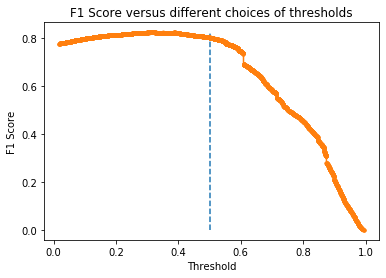

In [34]:
%matplotlib inline 
import numpy as np
import matplotlib.pyplot as plt
# Calculate the F1 score using different values for the classification threshold, 
# and pick the threshold that resulted in the highest F1 score.
highest_f1 = 0
threshold_highest_f1 = 0
f1_scores = []
for id, threshold in enumerate(thresholds):

    f1_score = 2*precisions[id]*recalls[id]/(precisions[id]+recalls[id])
    f1_scores.append(f1_score)
    if(f1_score > highest_f1):
        highest_f1 = f1_score
        threshold_highest_f1 = threshold
print("Highest F1 score on Validation:", highest_f1, \
      ", Threshold for the highest F1 score:", threshold_highest_f1)
# Let's plot the F1 score versus different choices of thresholds
plt.plot([0.5, 0.5], [np.min(f1_scores), np.max(f1_scores)], linestyle='--')
plt.plot(thresholds, f1_scores, marker='.')
plt.title('F1 Score versus different choices of thresholds')
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.show()